In [47]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# 1. Load and Visualize Data

## 1.1 Load Data

In [82]:
diabetes_data = pd.read_csv('diabetes.csv')

# Extract features and labels ('Outcome')
features = diabetes_data.drop(columns=['Outcome'])
labels = diabetes_data['Outcome']
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: (768, 8)
Labels shape: (768,)


In [83]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 1.2 Visualize Data

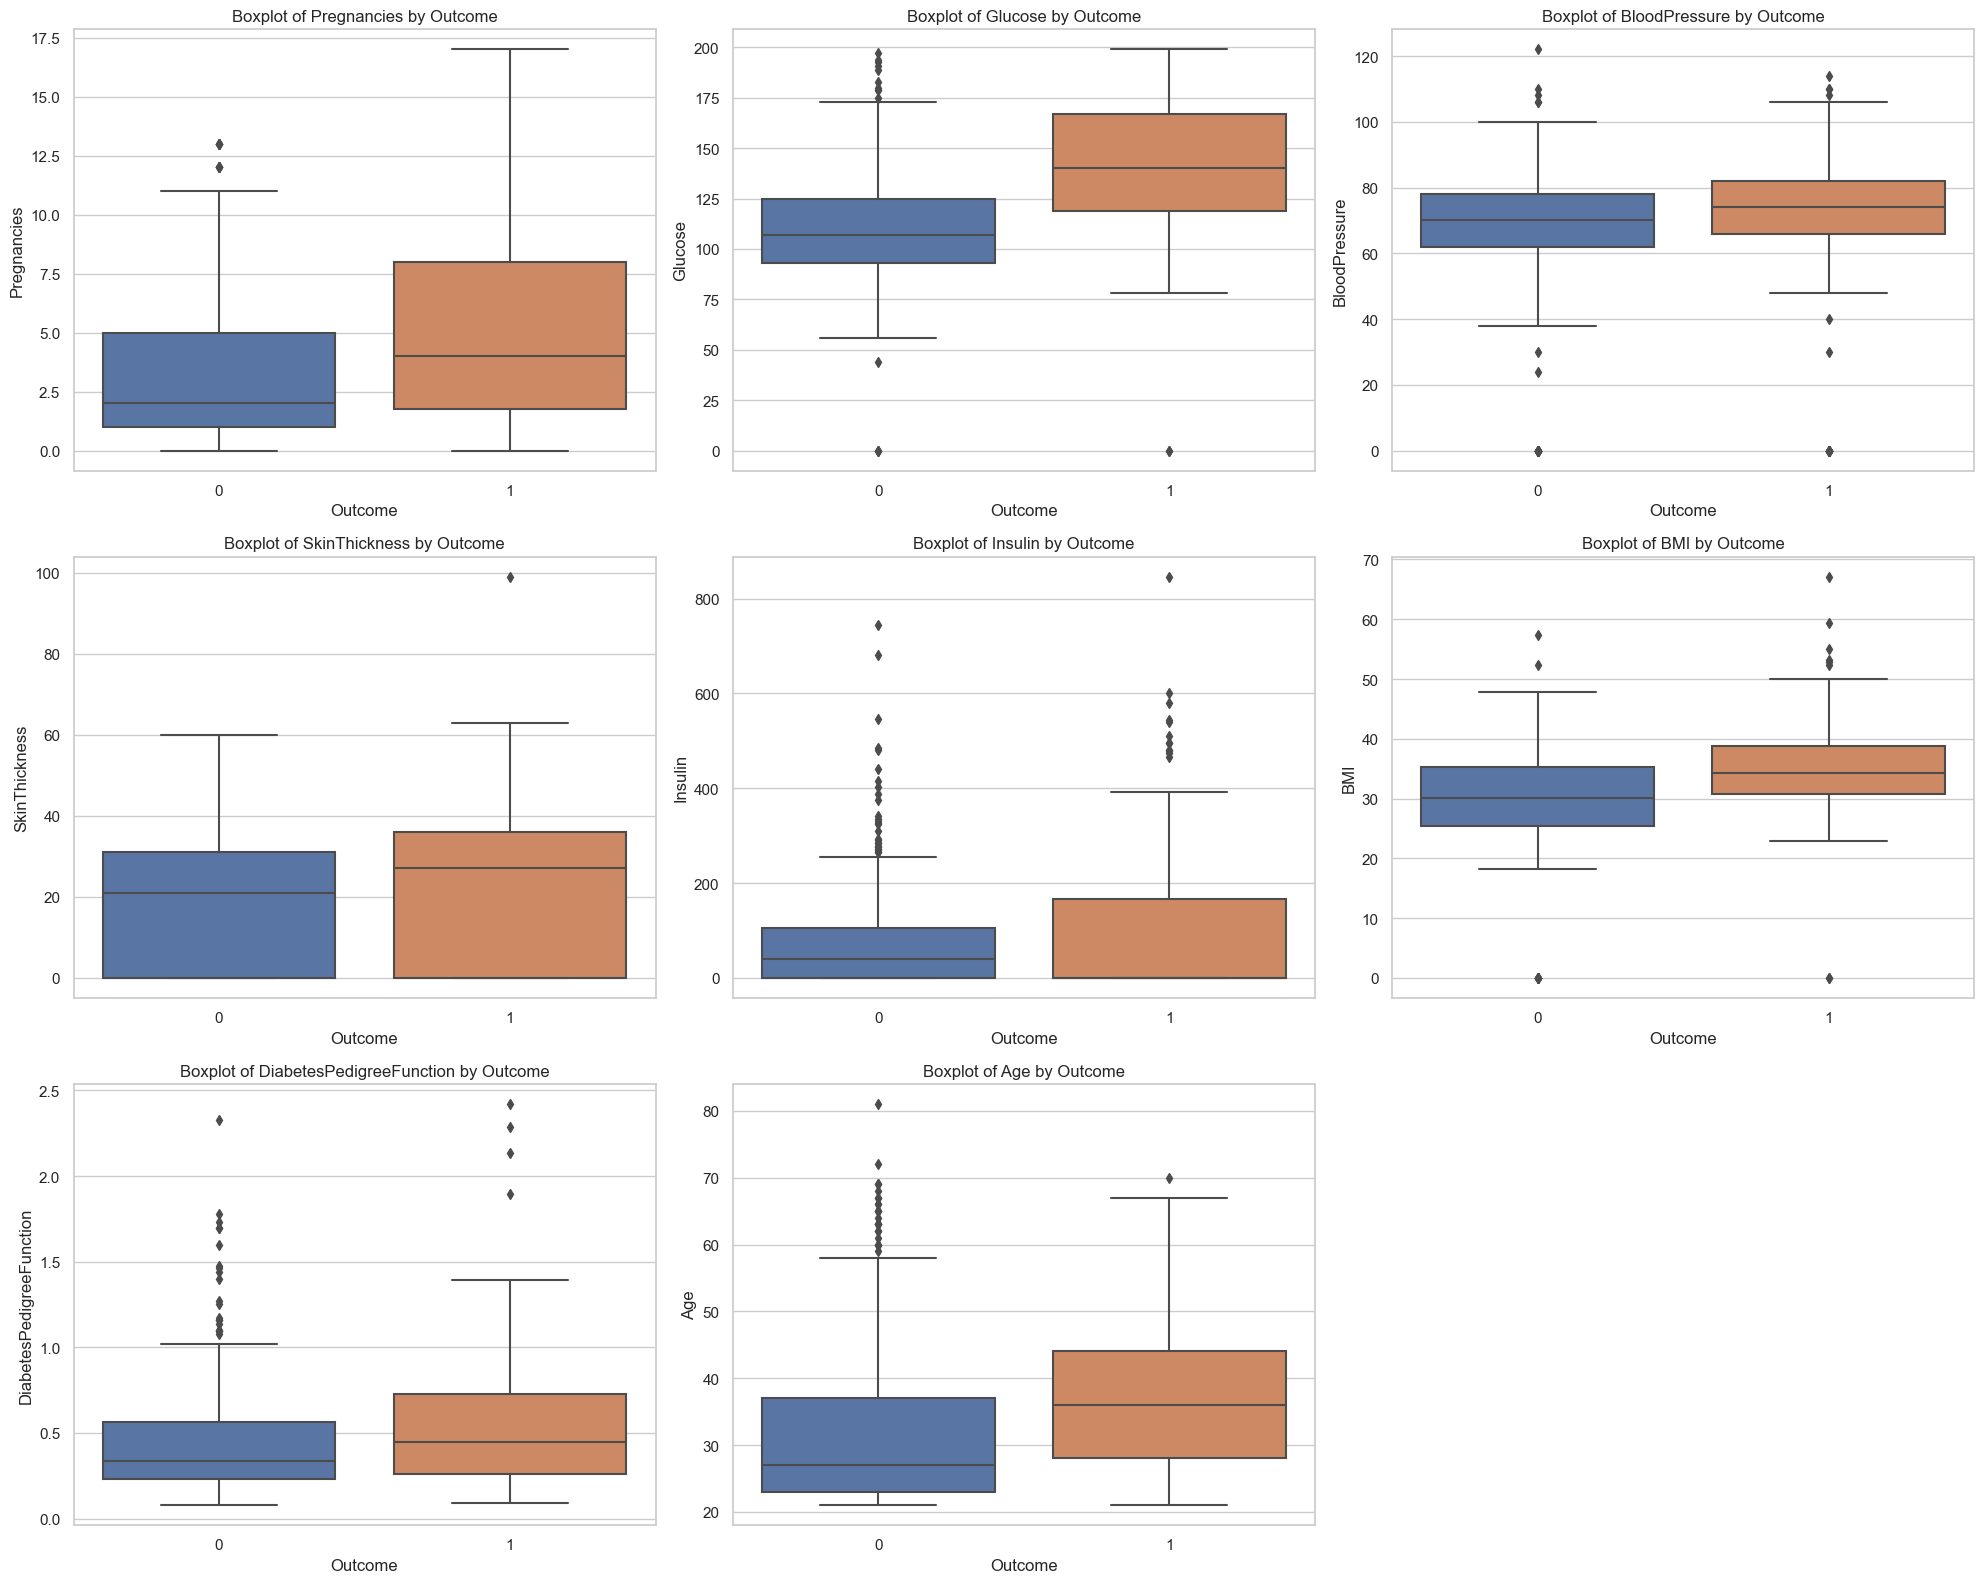

In [96]:


# 3. 每个特征按 Outcome 分组的箱线图
features = diabetes_data.columns[:-1]
plt.figure(figsize=(20, 16))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='Outcome', y=feature, data=diabetes_data)
    plt.title(f'Boxplot of {feature} by Outcome')
plt.tight_layout()
plt.show()



# 2. Split the Data and Pre-process

## 2.1 Split Data 

In [76]:
from sklearn.model_selection import train_test_split, StratifiedKFold

X = filtered_data.drop(columns=['Outcome'])
y = filtered_data['Outcome']

# 80% for training and validation, 20% for final testing.
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 5 fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1902621)

# Iterate through each fold
for fold, (train_index, val_index) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"Fold {fold + 1}")

    # Indexes of the training and validation sets
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
    y_train = np.array(y_train)
    y_val = np.array(y_val)

    # Print the shape of each fold
    print(f"Training data shape : {X_train.shape}")
    print(f"Training label shape : {y_train.shape}")
    print(f"Validation data shape : {X_val.shape}")
    print(f"Validation label shape : {y_val.shape}")

print(f"Test data shape : {X_test.shape}")
print(f"Test label shape : {y_test.shape}")


Fold 1
Training data shape : (491, 8)
Training label shape : (491,)
Validation data shape : (123, 8)
Validation label shape : (123,)
Fold 2
Training data shape : (491, 8)
Training label shape : (491,)
Validation data shape : (123, 8)
Validation label shape : (123,)
Fold 3
Training data shape : (491, 8)
Training label shape : (491,)
Validation data shape : (123, 8)
Validation label shape : (123,)
Fold 4
Training data shape : (491, 8)
Training label shape : (491,)
Validation data shape : (123, 8)
Validation label shape : (123,)
Fold 5
Training data shape : (492, 8)
Training label shape : (492,)
Validation data shape : (122, 8)
Validation label shape : (122,)
Test data shape : (154, 8)
Test label shape : (154,)


## 2.2 Pre-processing 

In [84]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define a pipeline for preprocessing
preproc_pl = Pipeline([
    ('imputer', IterativeImputer(random_state=42)),  # Impute np.nan values using IterativeImputer
    ('scaler', StandardScaler())
])

# Apply the preprocessing pipeline to the training and validation data
X_train_processed = preproc_pl.fit_transform(X_train)
X_val_processed = preproc_pl.transform(X_val)

## 2.3 Measure Models

In [67]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

def show_epoch(history):
    metrics_list = ['loss', 'accuracy', 'f1score', 'recall']
    num_metrics = len(metrics_list)
    num_cols = 2
    num_rows = (num_metrics + 1) // num_cols

    plt.figure(figsize=(15, num_rows * 5))

    for i, metric in enumerate(metrics_list):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()
    
f1score_metric = tf.keras.metrics.F1Score(average='weighted')

def f1score(y_true, y_pred):
    y_true = tf.reshape(y_true, (-1, 1))
    y_pred = tf.round(y_pred)

    f1score_metric.reset_state()
    f1score_metric.update_state(y_true, y_pred)
    
    return f1score_metric.result()

def calculate_performance_metrics(y_true, y_pred, model_name):
    """
    Calculate and return the performance metrics including accuracy, recall, precision, F1-score,
    and confusion matrix.
    """
    # Calculate performance metrics
    accuracy_val = accuracy_score(y_true, y_pred)
    recall_val = recall_score(y_true, y_pred, average='weighted')
    precision_val = precision_score(y_true, y_pred, average='weighted')
    f1_val = f1_score(y_true, y_pred, average='weighted')

    conf_matrix_val = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(conf_matrix_val, annot=True, fmt='d', xticklabels=['0 (Non Diabetic)', '1 (Diabetic)'], yticklabels=['0 (Non Diabetic)', '1 (Diabetic)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Return the metrics in a dictionary
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_val,
        'Recall': recall_val,
        'Precision': precision_val,
        'F1 Score': f1_val,
    }

    return metrics

# 3. Models

## 3.1 Support Vector Machines

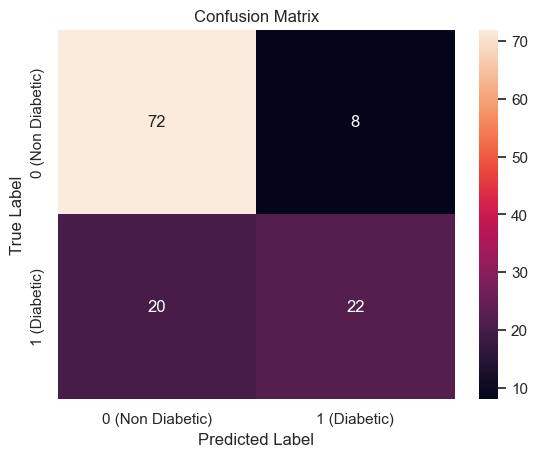

SVM Model Metrics:
{'Model': 'SVM Model', 'Accuracy': 0.7704918032786885, 'Recall': 0.7704918032786885, 'Precision': 0.7656450463292944, 'F1 Score': 0.7593722201042064}


In [79]:
from sklearn.svm import SVC

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preproc_pl),
    ('classifier', SVC(random_state=1902621))
])

svm_pipeline.fit(X_train, y_train)
y_pred_val_svm = svm_pipeline.predict(X_val)
svm_metrics = calculate_performance_metrics(y_val, y_pred_val_svm, 'SVM Model')
print('SVM Model Metrics:')
print(svm_metrics)

## 3.2 Single Layer Perceptron (SLP) - Baseline

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6249 - f1score: 0.4980 - loss: 0.7183 - precision: 0.4456 - recall: 0.5916 - val_accuracy: 0.6311 - val_f1score: 0.4956 - val_loss: 0.7529 - val_precision: 0.4694 - val_recall: 0.5476
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6133 - f1score: 0.5049 - loss: 0.7376 - precision: 0.4574 - recall: 0.5736 - val_accuracy: 0.6475 - val_f1score: 0.5149 - val_loss: 0.7410 - val_precision: 0.4898 - val_recall: 0.5714
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6148 - f1score: 0.5010 - loss: 0.7399 - precision: 0.4629 - recall: 0.5782 - val_accuracy: 0.6639 - val_f1score: 0.5418 - val_loss: 0.7301 - val_precision: 0.5102 - val_recall: 0.5952
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6277 - f1score: 0.5321 - loss: 0.7315 - precision: 0.4763 - recall: 0.6137 - val_accuracy: 0.6639 - val_f1score: 0.5418 - val_loss: 0.7195 - val_precision: 0.5102 - val_recall: 0.5952
Epo

Epoch 30/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7524 - f1score: 0.6544 - loss: 0.5146 - precision: 0.6539 - recall: 0.6756 - val_accuracy: 0.7787 - val_f1score: 0.6582 - val_loss: 0.5475 - val_precision: 0.7027 - val_recall: 0.6190
Epoch 31/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6782 - f1score: 0.5598 - loss: 0.5949 - precision: 0.5480 - recall: 0.5908 - val_accuracy: 0.7705 - val_f1score: 0.6420 - val_loss: 0.5441 - val_precision: 0.6944 - val_recall: 0.5952
Epoch 32/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7354 - f1score: 0.6016 - loss: 0.5429 - precision: 0.6066 - recall: 0.6153 - val_accuracy: 0.7705 - val_f1score: 0.6420 - val_loss: 0.5408 - val_precision: 0.6944 - val_recall: 0.5952
Epoch 33/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7564 - f1score: 0.6691 - loss: 0.5145 - precision: 0.6834 - recall: 0.6784 - val_accuracy: 0.7705 - val_f1score: 0.6420 - val_loss: 0.5380 - val_precision: 0.6944 - val_recall: 0.5952


Epoch 59/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8020 - f1score: 0.6768 - loss: 0.4482 - precision: 0.7398 - recall: 0.6388 - val_accuracy: 0.7951 - val_f1score: 0.6943 - val_loss: 0.4920 - val_precision: 0.7297 - val_recall: 0.6429
Epoch 60/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7737 - f1score: 0.6692 - loss: 0.5111 - precision: 0.7044 - recall: 0.6673 - val_accuracy: 0.7869 - val_f1score: 0.6764 - val_loss: 0.4913 - val_precision: 0.7222 - val_recall: 0.6190
Epoch 61/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7783 - f1score: 0.6617 - loss: 0.4742 - precision: 0.7030 - recall: 0.6273 - val_accuracy: 0.7869 - val_f1score: 0.6764 - val_loss: 0.4904 - val_precision: 0.7222 - val_recall: 0.6190
Epoch 62/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7778 - f1score: 0.6558 - loss: 0.4617 - precision: 0.6992 - recall: 0.6101 - val_accuracy: 0.7869 - val_f1score: 0.6764 - val_loss: 0.4896 - val_precision: 0.7222 - val_recall: 0.6190


Epoch 88/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7827 - f1score: 0.6207 - loss: 0.4745 - precision: 0.6789 - recall: 0.6134 - val_accuracy: 0.7623 - val_f1score: 0.6195 - val_loss: 0.4781 - val_precision: 0.6757 - val_recall: 0.5952
Epoch 89/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8003 - f1score: 0.6538 - loss: 0.4503 - precision: 0.7396 - recall: 0.6025 - val_accuracy: 0.7623 - val_f1score: 0.6195 - val_loss: 0.4780 - val_precision: 0.6757 - val_recall: 0.5952
Epoch 90/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7950 - f1score: 0.6740 - loss: 0.4558 - precision: 0.7216 - recall: 0.6407 - val_accuracy: 0.7623 - val_f1score: 0.6195 - val_loss: 0.4777 - val_precision: 0.6757 - val_recall: 0.5952
Epoch 91/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7612 - f1score: 0.6112 - loss: 0.4894 - precision: 0.6705 - recall: 0.5662 - val_accuracy: 0.7623 - val_f1score: 0.6195 - val_loss: 0.4775 - val_precision: 0.6757 - val_recall: 0.5952


Epoch 117/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7922 - f1score: 0.6471 - loss: 0.4495 - precision: 0.7490 - recall: 0.6002 - val_accuracy: 0.7705 - val_f1score: 0.6340 - val_loss: 0.4758 - val_precision: 0.6842 - val_recall: 0.6190
Epoch 118/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7837 - f1score: 0.6640 - loss: 0.4572 - precision: 0.7663 - recall: 0.5910 - val_accuracy: 0.7705 - val_f1score: 0.6340 - val_loss: 0.4757 - val_precision: 0.6842 - val_recall: 0.6190
Epoch 119/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7967 - f1score: 0.6511 - loss: 0.4493 - precision: 0.7293 - recall: 0.6219 - val_accuracy: 0.7705 - val_f1score: 0.6340 - val_loss: 0.4756 - val_precision: 0.6842 - val_recall: 0.6190
Epoch 120/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7960 - f1score: 0.6759 - loss: 0.4403 - precision: 0.7868 - recall: 0.6066 - val_accuracy: 0.7705 - val_f1score: 0.6340 - val_loss: 0.4756 - val_precision: 0.6842 - val_recall: 0.6

Epoch 146/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7616 - f1score: 0.6507 - loss: 0.4782 - precision: 0.7237 - recall: 0.5872 - val_accuracy: 0.7705 - val_f1score: 0.6340 - val_loss: 0.4771 - val_precision: 0.6842 - val_recall: 0.6190
Epoch 147/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8114 - f1score: 0.6756 - loss: 0.4234 - precision: 0.7610 - recall: 0.6365 - val_accuracy: 0.7705 - val_f1score: 0.6340 - val_loss: 0.4772 - val_precision: 0.6842 - val_recall: 0.6190
Epoch 148/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7962 - f1score: 0.6751 - loss: 0.4548 - precision: 0.7271 - recall: 0.6625 - val_accuracy: 0.7705 - val_f1score: 0.6340 - val_loss: 0.4775 - val_precision: 0.6842 - val_recall: 0.6190
Epoch 149/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8138 - f1score: 0.6982 - loss: 0.4302 - precision: 0.7709 - recall: 0.6702 - val_accuracy: 0.7705 - val_f1score: 0.6340 - val_loss: 0.4775 - val_precision: 0.6842 - val_recall: 0.6

Epoch 175/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7851 - f1score: 0.6266 - loss: 0.4359 - precision: 0.7327 - recall: 0.5820 - val_accuracy: 0.7705 - val_f1score: 0.6272 - val_loss: 0.4799 - val_precision: 0.6944 - val_recall: 0.5952
Epoch 176/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8060 - f1score: 0.6917 - loss: 0.4222 - precision: 0.7636 - recall: 0.6378 - val_accuracy: 0.7705 - val_f1score: 0.6272 - val_loss: 0.4800 - val_precision: 0.6944 - val_recall: 0.5952
Epoch 177/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8208 - f1score: 0.7075 - loss: 0.4202 - precision: 0.7920 - recall: 0.6446 - val_accuracy: 0.7705 - val_f1score: 0.6272 - val_loss: 0.4801 - val_precision: 0.6944 - val_recall: 0.5952
Epoch 178/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7944 - f1score: 0.6330 - loss: 0.4447 - precision: 0.7164 - recall: 0.6034 - val_accuracy: 0.7705 - val_f1score: 0.6272 - val_loss: 0.4802 - val_precision: 0.6944 - val_recall: 0.5

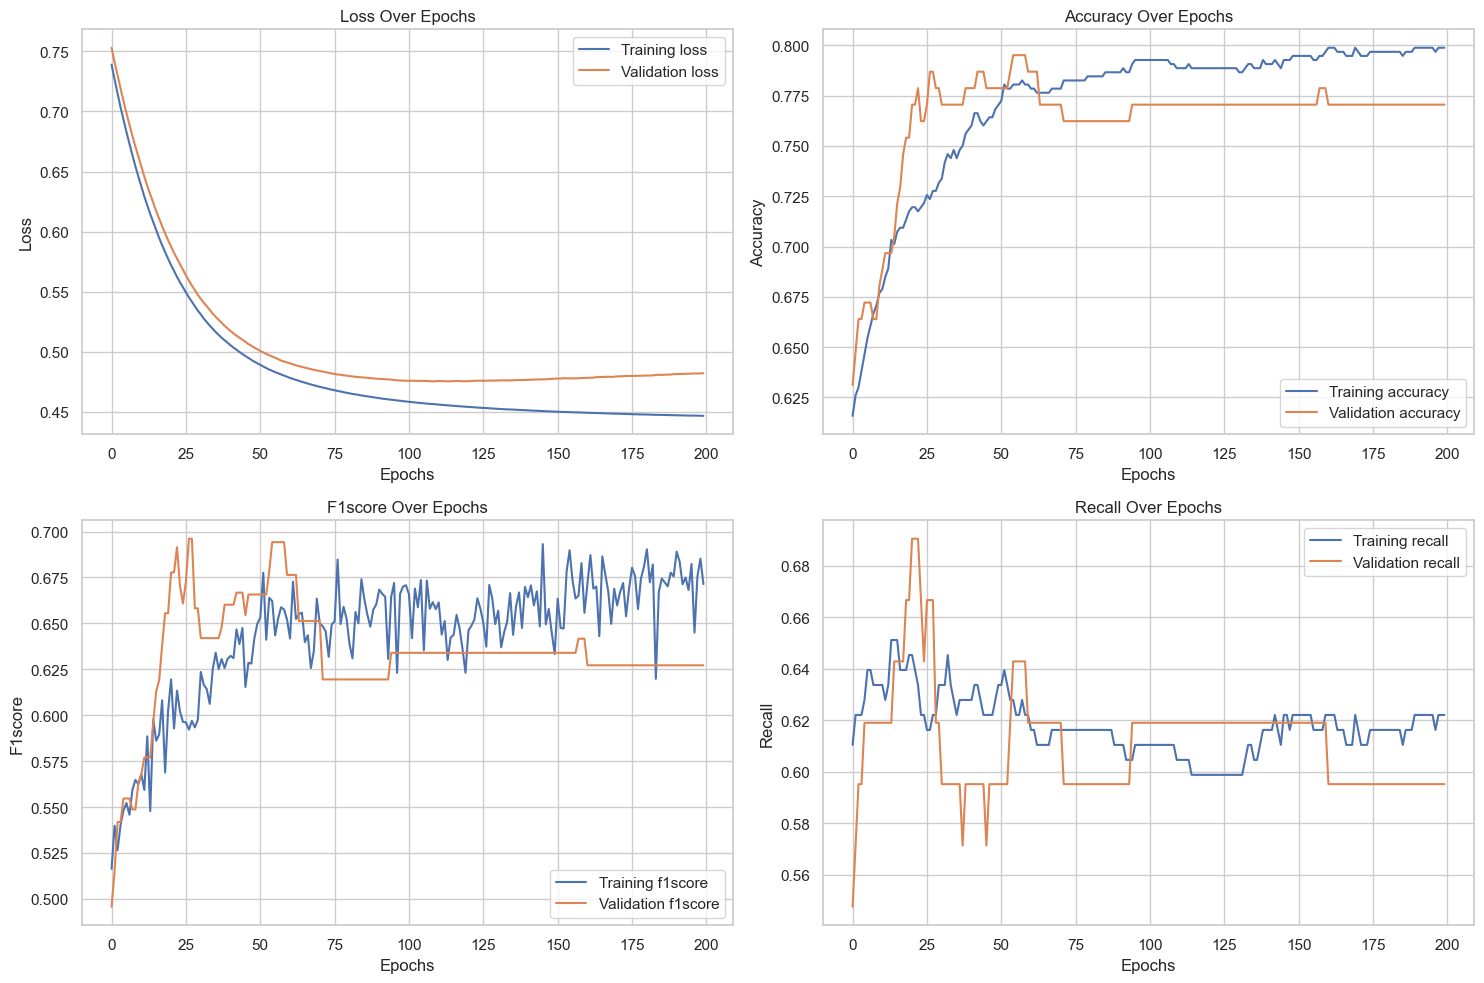

In [69]:
# Define the baseline Single Layer Perceptron (SLP) model
baseline_slp_model = keras.Sequential([
    keras.layers.Input(shape=(X_train_processed.shape[1],)), 
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_slp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall', 'precision', f1score])

baseline_slp_history = baseline_slp_model.fit(
    X_train_processed, y_train, 
    epochs=200,
    validation_data=(X_val_processed, y_val), 
    batch_size=32
)

show_epoch(baseline_slp_history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


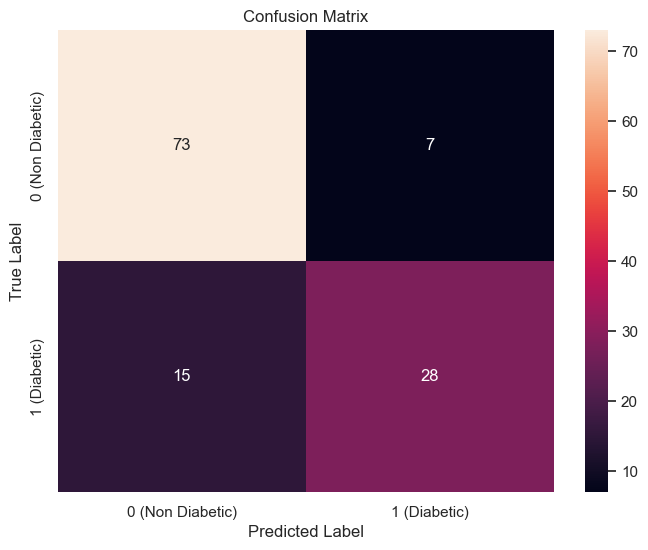

{'Model': 'Baseline SLP Model', 'Accuracy': 0.8211382113821138, 'Recall': 0.8211382113821138, 'Precision': 0.8192165558019218, 'F1 Score': 0.8162244259805236}


In [30]:
y_pred_baseline_slp = baseline_slp_model.predict(X_val_processed)

# Convert predicted probabilities to binary classes (0 or 1)
y_pred_classes_baseline_slp = (y_pred_baseline_slp > 0.5).astype(int)
y_true_classes_baseline_slp = y_val

baseline_slp_metrics = calculate_performance_metrics(y_true_classes_baseline_slp, y_pred_classes_baseline_slp, "Baseline SLP Model")
print(baseline_slp_metrics)

## 3.3 Single Layer Perceptron (SLP) - Early Stopping

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3099 - f1score: 0.2542 - loss: 1.1300 - precision: 0.2055 - recall: 0.3433 - val_accuracy: 0.3197 - val_f1score: 0.2097 - val_loss: 1.1185 - val_precision: 0.1846 - val_recall: 0.2857
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3229 - f1score: 0.2160 - loss: 1.1009 - precision: 0.1808 - recall: 0.2918 - val_accuracy: 0.3361 - val_f1score: 0.2146 - val_loss: 1.0933 - val_precision: 0.1905 - val_recall: 0.2857
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3269 - f1score: 0.2226 - loss: 1.0829 - precision: 0.1942 - recall: 0.3076 - val_accuracy: 0.3443 - val_f1score: 0.2171 - val_loss: 1.0687 - val_precision: 0.1935 - val_recall: 0.2857
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3154 - f1score: 0.2024 - loss: 1.0904 - precision: 0.1758 - recall: 0.2553 - val_accuracy: 0.3443 - val_f1score: 0.2171 - val_loss: 1.0453 - val_precision: 0.1935 - val_recall: 0.2857
Epo

Epoch 30/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6129 - f1score: 0.4204 - loss: 0.6251 - precision: 0.4046 - recall: 0.4454 - val_accuracy: 0.6311 - val_f1score: 0.4948 - val_loss: 0.6884 - val_precision: 0.4681 - val_recall: 0.5238
Epoch 31/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5999 - f1score: 0.4333 - loss: 0.6498 - precision: 0.4440 - recall: 0.4491 - val_accuracy: 0.6393 - val_f1score: 0.5186 - val_loss: 0.6806 - val_precision: 0.4792 - val_recall: 0.5476
Epoch 32/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6200 - f1score: 0.4323 - loss: 0.6436 - precision: 0.4515 - recall: 0.4302 - val_accuracy: 0.6639 - val_f1score: 0.5496 - val_loss: 0.6732 - val_precision: 0.5106 - val_recall: 0.5714
Epoch 33/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6400 - f1score: 0.4248 - loss: 0.6196 - precision: 0.4555 - recall: 0.4236 - val_accuracy: 0.6475 - val_f1score: 0.5219 - val_loss: 0.6660 - val_precision: 0.4894 - val_recall: 0.5476


Epoch 59/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7480 - f1score: 0.6119 - loss: 0.5082 - precision: 0.6895 - recall: 0.5520 - val_accuracy: 0.7213 - val_f1score: 0.5981 - val_loss: 0.5500 - val_precision: 0.6053 - val_recall: 0.5476
Epoch 60/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7507 - f1score: 0.5965 - loss: 0.5146 - precision: 0.6575 - recall: 0.5751 - val_accuracy: 0.7295 - val_f1score: 0.6048 - val_loss: 0.5469 - val_precision: 0.6216 - val_recall: 0.5476
Epoch 61/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7294 - f1score: 0.5523 - loss: 0.5182 - precision: 0.6528 - recall: 0.5093 - val_accuracy: 0.7295 - val_f1score: 0.6048 - val_loss: 0.5444 - val_precision: 0.6216 - val_recall: 0.5476
Epoch 62/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7543 - f1score: 0.5806 - loss: 0.4979 - precision: 0.6713 - recall: 0.5396 - val_accuracy: 0.7295 - val_f1score: 0.6048 - val_loss: 0.5418 - val_precision: 0.6216 - val_recall: 0.5476


Epoch 88/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7646 - f1score: 0.5954 - loss: 0.4922 - precision: 0.6985 - recall: 0.5504 - val_accuracy: 0.7541 - val_f1score: 0.6591 - val_loss: 0.4983 - val_precision: 0.6500 - val_recall: 0.6190
Epoch 89/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7496 - f1score: 0.6083 - loss: 0.4949 - precision: 0.7001 - recall: 0.5480 - val_accuracy: 0.7541 - val_f1score: 0.6591 - val_loss: 0.4972 - val_precision: 0.6500 - val_recall: 0.6190
Epoch 90/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7365 - f1score: 0.6044 - loss: 0.5029 - precision: 0.6933 - recall: 0.5442 - val_accuracy: 0.7541 - val_f1score: 0.6591 - val_loss: 0.4962 - val_precision: 0.6500 - val_recall: 0.6190
Epoch 91/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7867 - f1score: 0.6562 - loss: 0.4492 - precision: 0.7412 - recall: 0.5988 - val_accuracy: 0.7541 - val_f1score: 0.6591 - val_loss: 0.4951 - val_precision: 0.6500 - val_recall: 0.6190


Epoch 117/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7707 - f1score: 0.6397 - loss: 0.4735 - precision: 0.7475 - recall: 0.5719 - val_accuracy: 0.7623 - val_f1score: 0.6698 - val_loss: 0.4784 - val_precision: 0.6585 - val_recall: 0.6429
Epoch 118/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7901 - f1score: 0.6551 - loss: 0.4598 - precision: 0.7504 - recall: 0.6167 - val_accuracy: 0.7623 - val_f1score: 0.6698 - val_loss: 0.4783 - val_precision: 0.6585 - val_recall: 0.6429
Epoch 119/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7797 - f1score: 0.6275 - loss: 0.4644 - precision: 0.6983 - recall: 0.5741 - val_accuracy: 0.7623 - val_f1score: 0.6698 - val_loss: 0.4778 - val_precision: 0.6585 - val_recall: 0.6429
Epoch 120/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8133 - f1score: 0.6782 - loss: 0.4304 - precision: 0.7665 - recall: 0.6353 - val_accuracy: 0.7623 - val_f1score: 0.6698 - val_loss: 0.4774 - val_precision: 0.6585 - val_recall: 0.6

Epoch 146/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7892 - f1score: 0.6703 - loss: 0.4470 - precision: 0.7661 - recall: 0.5931 - val_accuracy: 0.7705 - val_f1score: 0.6650 - val_loss: 0.4715 - val_precision: 0.6842 - val_recall: 0.6190
Epoch 147/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8183 - f1score: 0.7178 - loss: 0.4548 - precision: 0.8123 - recall: 0.6670 - val_accuracy: 0.7705 - val_f1score: 0.6650 - val_loss: 0.4716 - val_precision: 0.6842 - val_recall: 0.6190
Epoch 148/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8053 - f1score: 0.6844 - loss: 0.4530 - precision: 0.7766 - recall: 0.6188 - val_accuracy: 0.7705 - val_f1score: 0.6650 - val_loss: 0.4713 - val_precision: 0.6842 - val_recall: 0.6190
Epoch 149/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7944 - f1score: 0.6405 - loss: 0.4434 - precision: 0.7649 - recall: 0.5843 - val_accuracy: 0.7787 - val_f1score: 0.6708 - val_loss: 0.4711 - val_precision: 0.7027 - val_recall: 0.6

Epoch 175/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8060 - f1score: 0.6924 - loss: 0.4497 - precision: 0.7771 - recall: 0.6308 - val_accuracy: 0.7705 - val_f1score: 0.6375 - val_loss: 0.4697 - val_precision: 0.6944 - val_recall: 0.5952
Epoch 176/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8123 - f1score: 0.6659 - loss: 0.4281 - precision: 0.7327 - recall: 0.6234 - val_accuracy: 0.7705 - val_f1score: 0.6375 - val_loss: 0.4697 - val_precision: 0.6944 - val_recall: 0.5952
Epoch 177/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8068 - f1score: 0.6495 - loss: 0.4537 - precision: 0.7386 - recall: 0.6262 - val_accuracy: 0.7705 - val_f1score: 0.6375 - val_loss: 0.4697 - val_precision: 0.6944 - val_recall: 0.5952
Epoch 178/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7919 - f1score: 0.6628 - loss: 0.4660 - precision: 0.7884 - recall: 0.6145 - val_accuracy: 0.7705 - val_f1score: 0.6375 - val_loss: 0.4699 - val_precision: 0.6944 - val_recall: 0.5

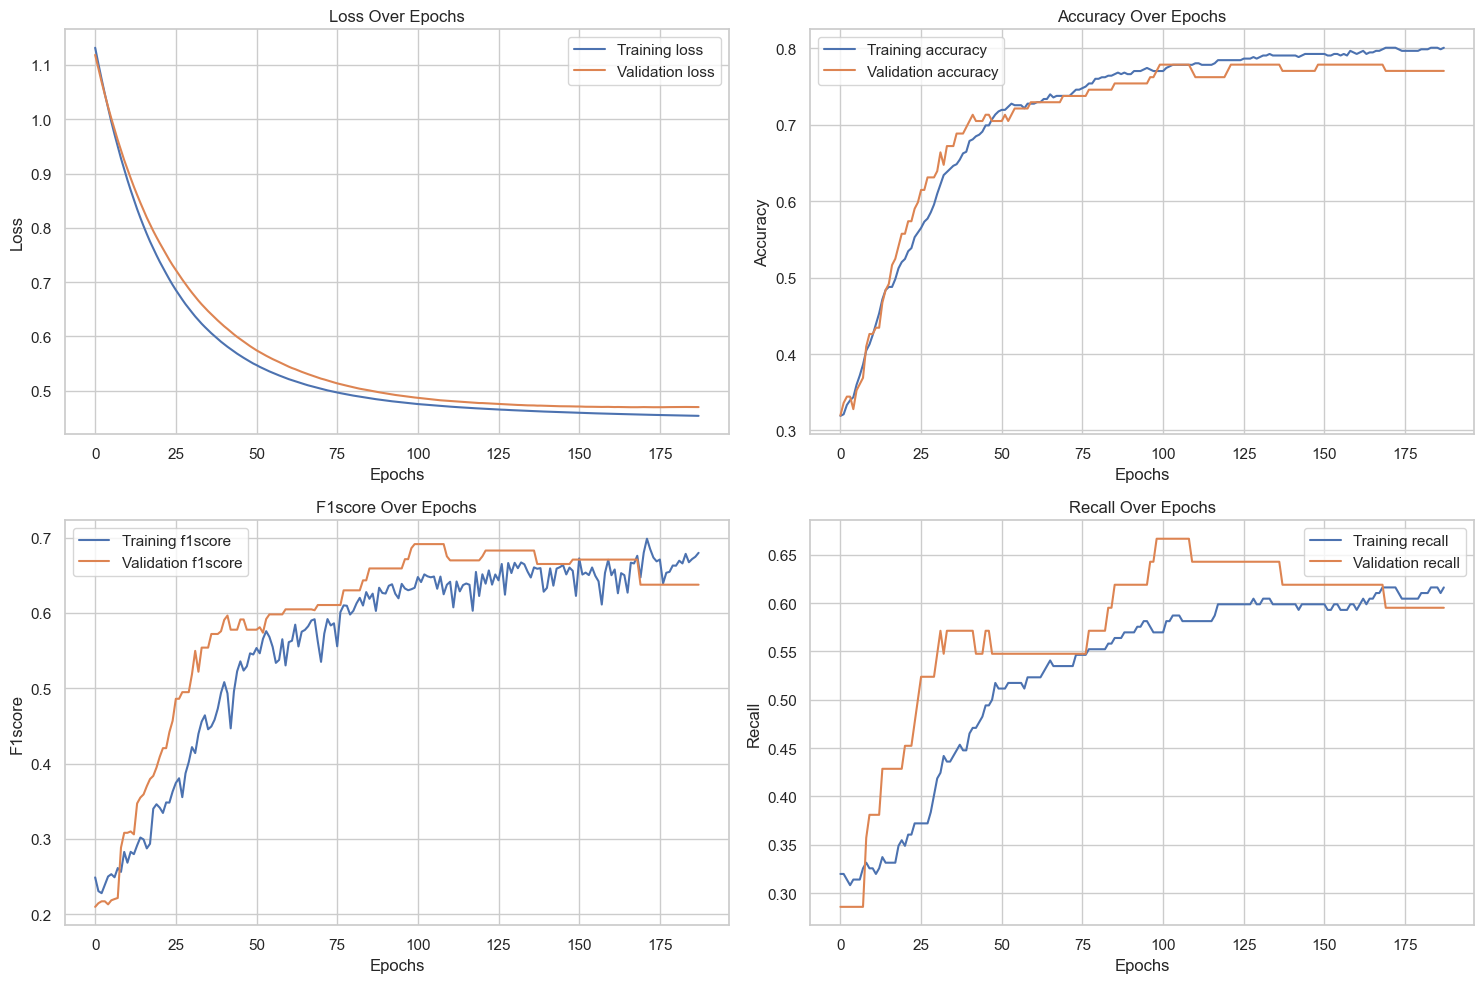

In [71]:
slp_opt1 = keras.Sequential([
    keras.layers.Input(shape=(X_train_processed.shape[1],)),   
    keras.layers.Dense(1, activation='sigmoid')               
])

slp_opt1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall', 'precision', f1score])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

slp_opt1_history = slp_opt1.fit(
    X_train_processed, y_train, 
    epochs=200, 
    validation_data=(X_val_processed, y_val), 
    callbacks=[early_stopping], 
    batch_size=32
)

show_epoch(slp_opt1_history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


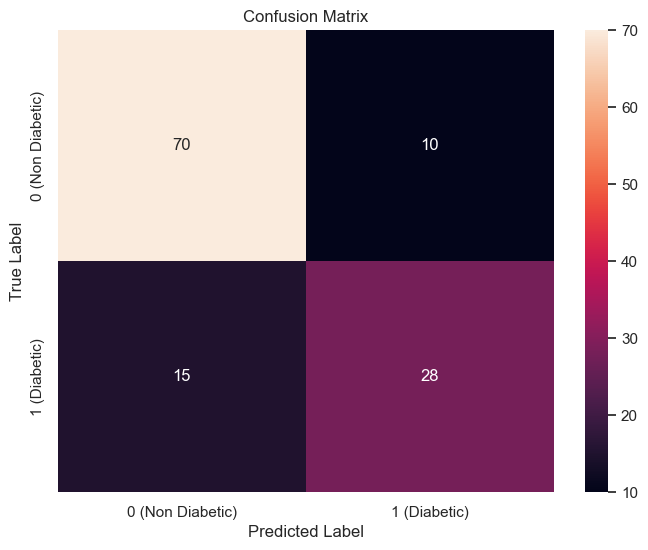

{'Model': 'SLP Model - Early Stopping', 'Accuracy': 0.7967479674796748, 'Recall': 0.7967479674796748, 'Precision': 0.7932240932316442, 'F1 Score': 0.7935543328497259}


In [32]:
y_pred_slp_opt1 = slp_opt1.predict(X_val_processed)
y_pred_classes_slp_opt1 = (y_pred_slp_opt1 > 0.5).astype(int)
y_true_classes_slp_opt1 = y_val

nn_slp_metrics = calculate_performance_metrics(y_true_classes_slp_opt1, y_pred_classes_slp_opt1, "SLP Model - Early Stopping")
print(nn_slp_metrics)

## 3.4 Model Multi Layer Perceptron

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5218 - f1score: 0.2390 - loss: 0.6898 - precision: 0.2487 - recall: 0.2366 - val_accuracy: 0.6148 - val_f1score: 0.3359 - val_loss: 0.6420 - val_precision: 0.4138 - val_recall: 0.2857
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6779 - f1score: 0.4637 - loss: 0.6045 - precision: 0.5157 - recall: 0.4279 - val_accuracy: 0.7131 - val_f1score: 0.5179 - val_loss: 0.5744 - val_precision: 0.6129 - val_recall: 0.4524
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7667 - f1score: 0.5992 - loss: 0.5375 - precision: 0.7835 - recall: 0.5269 - val_accuracy: 0.7541 - val_f1score: 0.6057 - val_loss: 0.5299 - val_precision: 0.6765 - val_recall: 0.5476
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7685 - f1score: 0.6304 - loss: 0.5066 - precision: 0.7214 - recall: 0.5634 - val_accuracy: 0.7541 - val_f1score: 0.5924 - val_loss: 0.5046 - val_precision: 0.6875 - val_recall: 0.5238
Epo

Epoch 30/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8058 - f1score: 0.6928 - loss: 0.4209 - precision: 0.7317 - recall: 0.6669 - val_accuracy: 0.7623 - val_f1score: 0.6063 - val_loss: 0.4574 - val_precision: 0.7097 - val_recall: 0.5238
Epoch 31/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8086 - f1score: 0.7102 - loss: 0.4208 - precision: 0.7698 - recall: 0.6713 - val_accuracy: 0.7623 - val_f1score: 0.6063 - val_loss: 0.4577 - val_precision: 0.7097 - val_recall: 0.5238
Epoch 32/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8145 - f1score: 0.6998 - loss: 0.3980 - precision: 0.7634 - recall: 0.6568 - val_accuracy: 0.7541 - val_f1score: 0.5982 - val_loss: 0.4605 - val_precision: 0.6875 - val_recall: 0.5238
Epoch 33/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8151 - f1score: 0.7057 - loss: 0.4036 - precision: 0.7628 - recall: 0.6741 - val_accuracy: 0.7541 - val_f1score: 0.5982 - val_loss: 0.4575 - val_precision: 0.6875 - val_recall: 0.5238


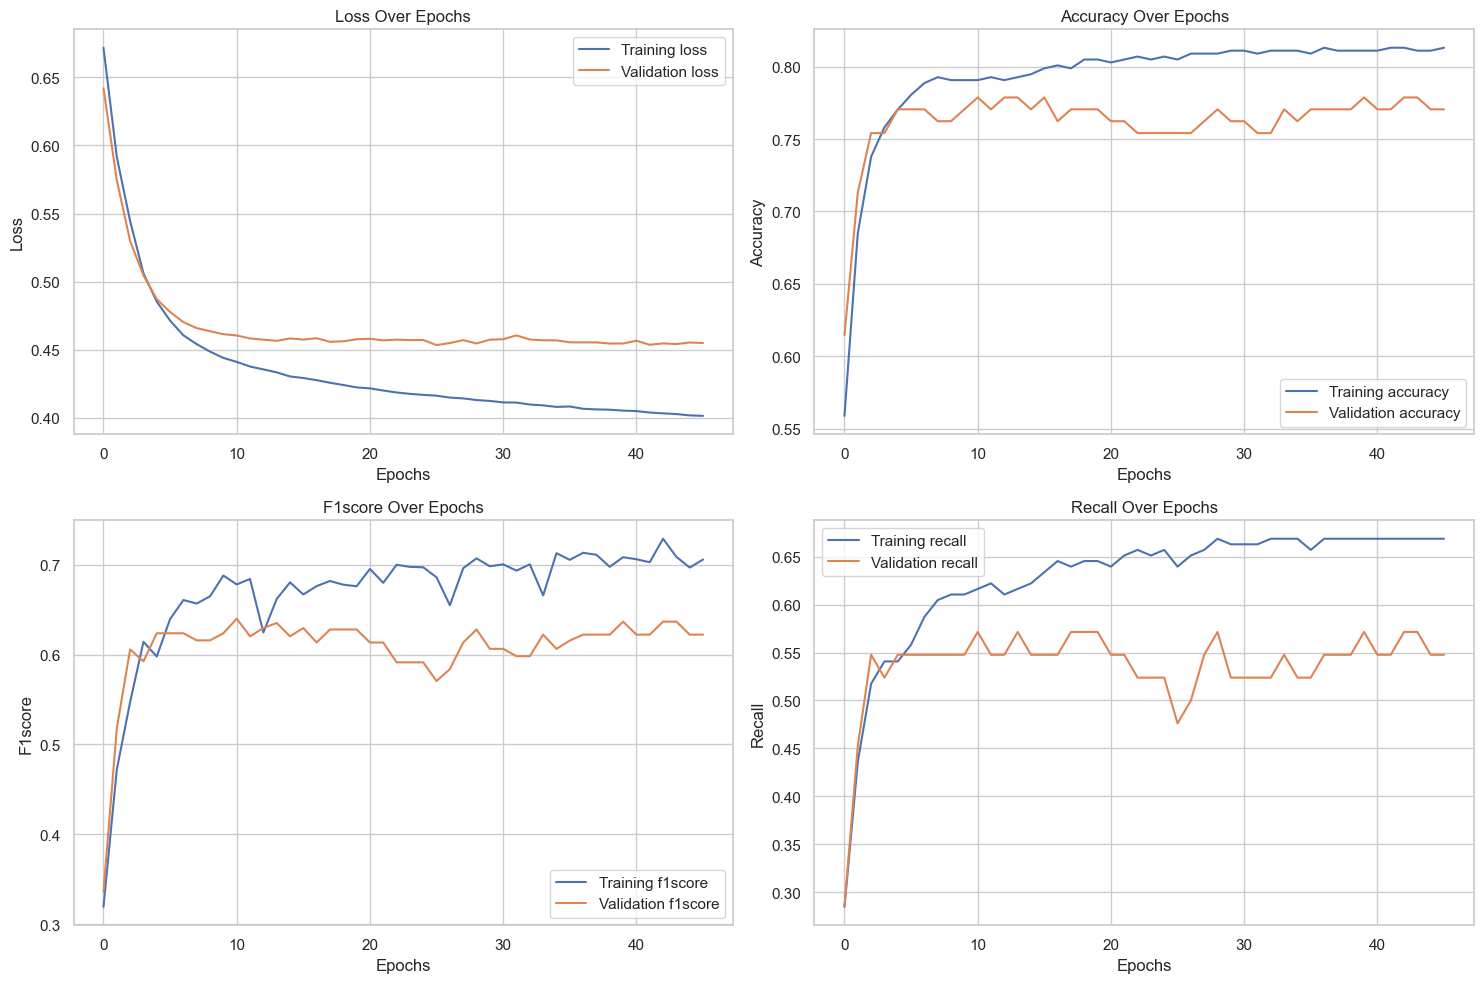

In [94]:
# Define the Multi-Layer Perceptron (MLP) model with 1 hidden layer
nn_mlp_model = keras.Sequential([
    keras.layers.Input(shape=(X_train_processed.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


nn_mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall', 'precision', f1score])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

nn_mlp_history = nn_mlp_model.fit(
    X_train_processed, y_train, 
    epochs=200, 
    validation_data=(X_val_processed, y_val), 
    callbacks=[early_stopping], 
    batch_size=32
)

show_epoch(nn_mlp_history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


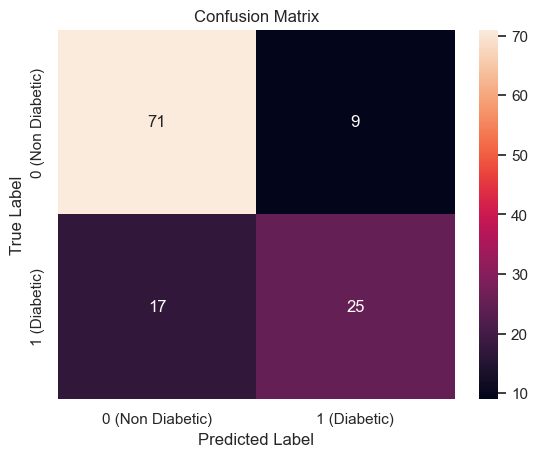

{'Model': 'NN MLP Model', 'Accuracy': 0.7868852459016393, 'Recall': 0.7868852459016393, 'Precision': 0.7821951433330412, 'F1 Score': 0.7807428407083281}


In [93]:
y_pred_nn_mlp_model = nn_mlp_model.predict(X_val_processed)
y_pred_classes_nn_mlp = (y_pred_nn_mlp_model > 0.5).astype(int)
y_true_classes_nn_mlp = y_val

nn_mlp_metrics = calculate_performance_metrics(y_true_classes_nn_mlp, y_pred_classes_nn_mlp, "NN MLP Model")
print(nn_mlp_metrics)

## 3.5 Comparing models

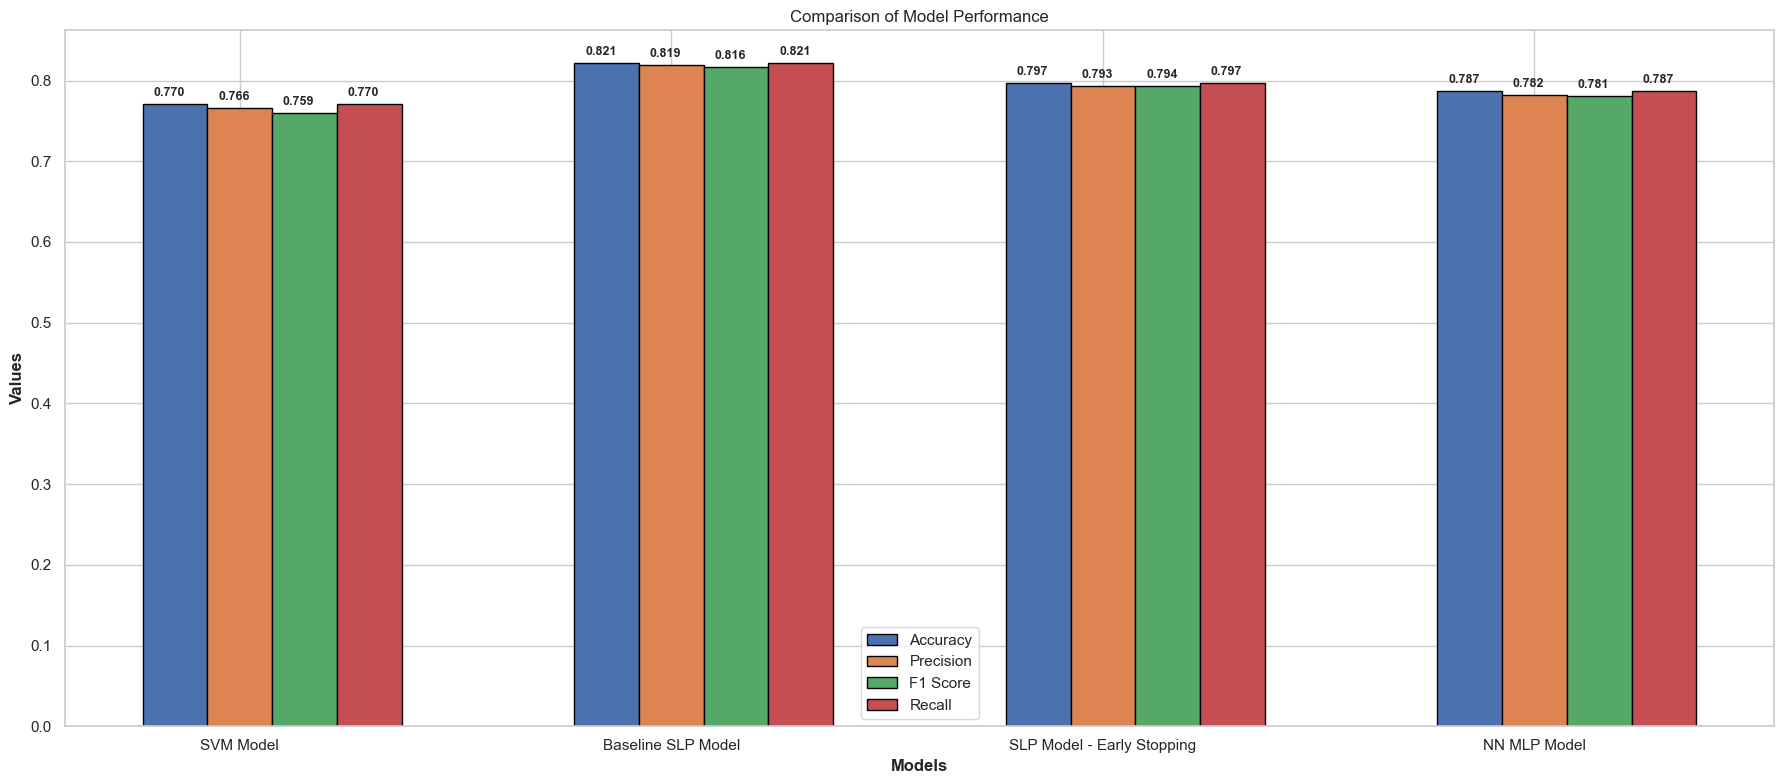

In [97]:
metrics_dicts = [svm_metrics, baseline_slp_metrics, nn_slp_metrics, nn_mlp_metrics]

metrics = ['Accuracy', 'Precision', 'F1 Score', 'Recall']
model_metrics = {metrics_dict['Model']: [metrics_dict[metric] for metric in metrics] for metrics_dict in metrics_dicts}

transposed_metrics = {metric: [model_metrics[model][i] for model in model_metrics] for i, metric in enumerate(metrics)}

bar_width = 0.15
positions = np.arange(len(model_metrics))
bar_positions = [positions + i * bar_width for i in range(len(metrics))]

# Create the bar plot
plt.figure(figsize=(18, 8))

# Plotting the bars
for i, (metric, values) in enumerate(transposed_metrics.items()):
    plt.bar(bar_positions[i], values, width=bar_width, edgecolor='black', label=metric)
    for j, v in enumerate(values):
        plt.text(bar_positions[i][j] - 0.05, v + 0.01, f'{v:.3f}', fontweight='bold', fontsize=9)

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Values', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(model_metrics))], model_metrics.keys())
plt.title('Comparison of Model Performance')
plt.legend()
plt.tight_layout()
plt.show()